# Assignment 2


You must submit your notebook by running `python3 -m autograder.run.submit Assignment2.ipynb` from your local repository.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. To do so, restart the kernel and run all cells (in the menubar, select Runtime→→Restart and run all).

#### Show your work!
Whenever you are asked to find the solution to a problem, be sure to also **show how you arrived** at your answer.

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWERS HERE", as well as your name below:

## Some Helper Functions

Implement an evaluation function that takes in some board position and player colour and returns a score. 

In [176]:
import chess
import random
from math import inf
from IPython.display import display, clear_output

In [247]:
def evaluation(b: chess.Board, player: bool):
    """
    This function evaluates a board position and returns a score value.
    
    Parameters:
    - board: the chess board that the knight is moving upon
    - player: the colour of the active player (True -> white, False -> black)
    
    Returns:
    - an integer score for a board state
    """
    # material values and piece-square tables based on this evaluation function: https://www.chessprogramming.org/Simplified_Evaluation_Function

    # material values
    material_values = {
        chess.KING: 20000,
        chess.QUEEN: 900,
        chess.ROOK: 500,
        chess.BISHOP: 330,
        chess.KNIGHT: 320,
        chess.PAWN: 100
    }
    
    # piece-square tables
    piece_square = {
        chess.PAWN: [
             0,  0,  0,  0,  0,  0,  0,  0,
            50, 50, 50, 50, 50, 50, 50, 50,
            10, 10, 20, 30, 30, 20, 10, 10,
             5,  5, 10, 25, 25, 10,  5,  5,
             0,  0,  0, 20, 20,  0,  0,  0,
             5, -5,-10,  0,  0,-10, -5,  5,
             5, 10, 10,-20,-20, 10, 10,  5,
             0,  0,  0,  0,  0,  0,  0,  0
        ],
        chess.KNIGHT: [
            -50,-40,-30,-30,-30,-30,-40,-50,
            -40,-20,  0,  0,  0,  0,-20,-40,
            -30,  0, 10, 15, 15, 10,  0,-30,
            -30,  5, 15, 20, 20, 15,  5,-30,
            -30,  0, 15, 20, 20, 15,  0,-30,
            -30,  5, 10, 15, 15, 10,  5,-30,
            -40,-20,  0,  5,  5,  0,-20,-40,
            -50,-40,-30,-30,-30,-30,-40,-50
        ],
        chess.BISHOP: [
            -20,-10,-10,-10,-10,-10,-10,-20,
            -10,  0,  0,  0,  0,  0,  0,-10,
            -10,  0,  5, 10, 10,  5,  0,-10,
            -10,  5,  5, 10, 10,  5,  5,-10,
            -10,  0, 10, 10, 10, 10,  0,-10,
            -10, 10, 10, 10, 10, 10, 10,-10,
            -10,  5,  0,  0,  0,  0,  5,-10,
            -20,-10,-10,-10,-10,-10,-10,-20
        ],
        chess.ROOK: [
             0,  0,  0,  0,  0,  0,  0,  0,
             5, 10, 10, 10, 10, 10, 10,  5,
            -5,  0,  0,  0,  0,  0,  0, -5,
            -5,  0,  0,  0,  0,  0,  0, -5,
            -5,  0,  0,  0,  0,  0,  0, -5,
            -5,  0,  0,  0,  0,  0,  0, -5,
            -5,  0,  0,  0,  0,  0,  0, -5,
             0,  0,  0,  5,  5,  0,  0,  0
        ],
        chess.QUEEN: [
            -20,-10,-10, -5, -5,-10,-10,-20,
            -10,  0,  0,  0,  0,  0,  0,-10,
            -10,  0,  5,  5,  5,  5,  0,-10,
             -5,  0,  5,  5,  5,  5,  0, -5,
              0,  0,  5,  5,  5,  5,  0, -5,
            -10,  5,  5,  5,  5,  5,  0,-10,
            -10,  0,  5,  0,  0,  0,  0,-10,
            -20,-10,-10, -5, -5,-10,-10,-20
        ],
        chess.KING: [
            -30,-40,-40,-50,-50,-40,-40,-30,
            -30,-40,-40,-50,-50,-40,-40,-30,
            -30,-40,-40,-50,-50,-40,-40,-30,
            -30,-40,-40,-50,-50,-40,-40,-30,
            -20,-30,-30,-40,-40,-30,-30,-20,
            -10,-20,-20,-20,-20,-20,-20,-10,
             20, 20,  0,  0,  0,  0, 20, 20,
             20, 30, 10,  0,  0, 10, 30, 20
        ]
    }

    king_end_game = [
        -50,-40,-30,-20,-20,-30,-40,-50,
        -30,-20,-10,  0,  0,-10,-20,-30,
        -30,-10, 20, 30, 30, 20,-10,-30,
        -30,-10, 30, 40, 40, 30,-10,-30,
        -30,-10, 30, 40, 40, 30,-10,-30,
        -30,-10, 20, 30, 30, 20,-10,-30,
        -30,-30,  0,  0,  0,  0,-30,-30,
        -50,-30,-30,-30,-30,-30,-30,-50
    ]

    eval_score = 0

    for piece_type, table in piece_square.items():
        # squares that have this piece type and color
        white_squares = b.pieces(piece_type, chess.WHITE)
        black_squares = b.pieces(piece_type, chess.BLACK)
        
        # check endgame for king 
        if piece_type == chess.KING and is_endgame(b):
            piece_table = king_end_game
        else:
            piece_table = table

        for square in white_squares:
            #mirrored_square = chess.square_mirror(square)
            eval_score += material_values[piece_type] * piece_table[square]
        
        for square in black_squares:
            #mirrored_square = chess.square_mirror(square)
            eval_score -= material_values[piece_type] * piece_table[square] 
    
    # check and checkmate evaluation
    # if b.is_check():
    #     if b.turn == player:  # If the player is in check, penalize
    #         eval_score -= 5000
    #     else:  # If opponent is in check, reward
    #         eval_score += 5000

    # if b.is_checkmate():
    #     if b.turn == player:  # Checkmate against the player
    #         eval_score += 999999 
    #     else:  # Checkmate against the opponent
    #         eval_score -= 999999

    return eval_score if player else -eval_score

def is_endgame(b: chess.Board):
    return False
    # check endgame condition - no queens
    if len(b.pieces(chess.QUEEN, chess.WHITE)) + len(b.pieces(chess.QUEEN, chess.BLACK)) == 0:
        return True
    
    # check endgame condition - only 1 queen on either side
    for color in [chess.WHITE, chess.BLACK]:
        if bin(b.occupied_co[color]).count("1") == 1 and len(b.pieces(chess.QUEEN, color)) == 1:
            return True

    return False

## Q1

Implement the minimax algorithm to choose the best chess move for a given board position, player colour, and look-ahead depth. Make use of your `evaluation()` function here to calculate the score of any individual board state.

In [94]:
def get_minimax_move(b: chess.Board, player: bool, depth: int):   
    """
    This function chooses the best move for the given board position, player, and depth.
    
    Parameters:
    - board: the chess board that the knight is moving upon
    - player: the colour of the active player (True -> white, False -> black)
    - depth: the number of moves that the algorithmn should look ahead.
    
    Returns:
    A single chess.Move type object.
    """
    # utilized pseudocode from alpha-beta pruning wiki: https://en.wikipedia.org/wiki/Alpha–beta_pruning
    def helper(local_b: chess.Board, local_player: bool, local_depth: int, alpha: int, beta: int):
        # base case
        if local_depth == 0 or local_b.is_game_over():
            return evaluation(local_b, local_player), None
        
        best_move = None

        # max implementation
        if local_player:
            best_val = -inf
            for move in local_b.legal_moves:
                local_b.push(move)
                val, _ = helper(local_b, not local_player, local_depth - 1, alpha, beta)
                local_b.pop()
                if val > best_val:
                    best_val = val
                    best_move = move
                alpha = max(alpha, val)
                if best_val >= beta: break
            return best_val, best_move
        
        # min implementation
        else: 
            best_val = inf
            for move in local_b.legal_moves:
                local_b.push(move)
                val, _ = helper(local_b, not local_player, local_depth - 1, alpha, beta)
                local_b.pop()
                if val < best_val:
                    best_val = val
                    best_move = move
                beta = min(beta, val)
                if best_val <= alpha: break
            return best_val, best_move
        
    optimal_value, optimal_move = helper(b.copy(), player, depth, -inf, inf)
    return optimal_move


## Q2

Implement the expectimax algorithm to choose the best chess move for a given board position, player colour, and look-ahead depth. Make use of your `evaluation()` function here to calculate the score of any individual board state.

In [130]:
def get_expectimax_move(b: chess.Board, player: bool, depth: int):   
    """
    This function chooses the best move for the given board position, player, and depth.
    
    Parameters:
    - board: the chess board that the knight is moving upon
    - player: the colour of the active player (True -> white, False -> black)
    - depth: the number of moves that the algorithmn should look ahead.
    
    Returns:
    A single chess.Move type object.
    """
    # utilized pseudocode from expectimax wiki: https://en.wikipedia.org/wiki/Expectiminimax
    def helper(local_b: chess.Board, local_player: bool, local_depth: int):
        if local_depth == 0 or local_b.is_game_over():
            return evaluation(local_b, local_player), None
        
        best_move = None
        
        if local_player:
            # max condition
            best_val = -inf
            for move in local_b.legal_moves:
                local_b.push(move)
                val, _ = helper(local_b, not local_player, local_depth - 1)
                local_b.pop()
                if val > best_val:
                    best_val = val
                    best_move = move
            return best_val, best_move
            
        else:
            # chance condition
            best_val = 0.0
            p = 1 / len(list(local_b.legal_moves))
            for move in local_b.legal_moves:
                local_b.push(move)
                val, _ = helper(local_b, not local_player, local_depth - 1)
                best_val += p * val
                local_b.pop()
            return best_val, best_move
        
    _, optimal_move = helper(b.copy(), player, depth)
    return optimal_move

## Q3

Plays against the strongest grading agent, so copy your best agent here.

In [245]:
def get_best_move(b: chess.Board, player: bool, depth: int):   
    """
    This function chooses the best move for the given board position, player, and depth.

    Parameters:
    - board: the chess board that the knight is moving upon
    - player: the colour of the active player (True -> white, False -> black)
    - depth: the number of moves that the algorithmn should look ahead.

    Returns:
    A single chess.Move type object.
    """  
    # utilized pseudocode from alpha-beta pruning wiki: https://en.wikipedia.org/wiki/Alpha–beta_pruning
    def helper(local_b: chess.Board, local_player: bool, local_depth: int, alpha: int, beta: int):
        # base case
        if local_depth == 0 or local_b.is_game_over():
            return evaluation(local_b, local_player)

        # max implementation
        if local_player:
            val = -inf
            for move in local_b.legal_moves:
                local_b.push(move)
                val = max(val, helper(local_b, not local_player, local_depth - 1, alpha, beta))
                local_b.pop()
                alpha = max(alpha, val)
                if beta <= alpha: break
            return val
        
        # min implementation
        else:
            val = inf
            for move in local_b.legal_moves:
                local_b.push(move)
                val = min(val, helper(local_b, not local_player, local_depth - 1, alpha, beta))
                local_b.pop()
                beta = min(beta, val)
                if beta <= alpha: break
            return val
        
    best_move = None
    best_val = -inf if player else inf

    for move in b.legal_moves:
        b.push(move)
        val = helper(b, not player, depth - 1, -inf, inf)
        b.pop()
        if player:
            if val > best_val:
                best_val = val
                best_move = move
        else:
            if val < best_val:
                best_val = val
                best_move = move
    
    return best_move

## Local Testing
For your convenience, here are some helper functions to run games and allow you to test your agents.

In [200]:
MAX_DEPTH = 3
SEED = random.Random(0)  # Feel free to set/reset the seed for testing purposes!

def get_random_move(b:chess.Board, *_):
    return SEED.choice(list(b.legal_moves))

def test_game(p1, p2):
    """
    A function that plays a chess game with visuals
    
    Parameters:
    - p1: the first chess agent, playing as the white player
    - p2: the second chess agent, playing as the black player
    
    Returns:
    Nothing, just plays the game one move at a time.
    Press enter in the popup box to play the next move.
    Type 'q' into the popup box and press enter to stop the game (you can also interrupt the kernel if this fails.)
    """
    board = chess.Board()
    current_player = p1

    while not board.is_checkmate()  and not board.is_stalemate() and not board.can_claim_draw():
        clear_output(True)
        
        move = current_player(board, board.turn, MAX_DEPTH)
        board.push(move)
        display(board)

        current_player = p1 if board.turn else p2

        if input() == "q":
            break
    

In [ ]:
# Random Vs. Random
random_agent = get_random_move
test_game(random_agent, random_agent)

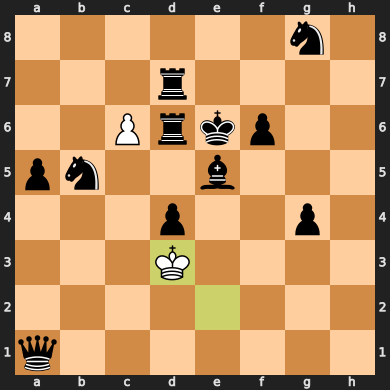

In [173]:
# Minimax Vs. Random
random_agent = get_random_move
minimax_agent = get_minimax_move
test_game(minimax_agent, random_agent)

In [ ]:
# Expectimax Vs. Random
random_agent = get_random_move
expectimax_agent = get_expectimax_move
test_game(expectimax_agent, random_agent)

In [13]:
# Run several games at once without graphics
def grade_game(p1, p2):
    """
    Grades a single game at a time.
    (Note: differs from actual grading script, which has some ways to resolve draws.)

    Return legend:
    0: error during game
    1: p1 wins through checkmate
    2: p2 wins through checkmate
    3: draw
    """
    board = chess.Board()
    current_player = p1

    while not board.is_checkmate() and not board.is_stalemate() and not board.can_claim_draw():
        move = current_player(board, board.turn, MAX_DEPTH)
        try:
            board.push(move)
        except:            
            print(f"Error while grading game, move = {move}, current_player = {current_player}")
            print(board)
            return -1

        current_player = p1 if board.turn else p2
    
    outcome = board.outcome()
    if outcome is not None:
        if outcome.winner:
            return 1
        else:
            return 2
    
    return 3

In [248]:
# Play many games in a row without visuals (faster)
random_agent = get_random_move
best_agent = get_best_move
num_games = 5

print(f"Playing {num_games} games...")
for i in range(1, num_games+1):
    result = grade_game(best_agent, random_agent)

    if result == 0:
        print(f"Game {i}: error pushing a move during gameplay")
        
    elif result == 1:
        print(f"Game {i}: p1 wins")
        
    elif result == 2:
        print(f"Game {i}: p1 loses")
    
    elif result == 3:
        print(f"Game {i}: draw")

Playing 5 games...
Game 1: draw


KeyboardInterrupt: 